In [1]:
import numpy as np
import pandas as pd
import os
import re
import random
import gc
import pydicom as pdc
from utils.datahandling_utils import createImageArray


c:\Users\svenalrik\anaconda3\envs\dev-env2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 41
BATCH_SIZE = 64
random.seed(SEED)


In [3]:
label_path = "D:/AIFs/AIFs/durable/BorrSci_MR_Data/Output"
image_path = "D:/iCAT_IMAGES"


In [4]:
data = pd.read_csv("data_indices.csv", ",", index_col=0)
data = data.sort_values(["Patient", "Volume", "Slice"], ignore_index=True)


C:\Users\svenalrik\AppData\Local\Temp\ipykernel_29500\991898945.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  data = pd.read_csv("data_indices.csv", ",", index_col=0)


In [5]:
# Import images (paths)
from utils.datahandling_utils import createImageIndexCSV
image_data = createImageIndexCSV(image_path)
# Import annotations
mca_labels = pd.read_excel('MCA_labels.xlsx')
# Patient 102(1) contains anomalies
mca_labels = mca_labels.drop(mca_labels[mca_labels['Patient'] == 1].index)
# Patient 112(11) lacks a single pixel array
mca_labels = mca_labels.drop(mca_labels[mca_labels['Patient'] == 11].index)
mca_labels = pd.melt(mca_labels, id_vars=[
                     'Patient'], var_name='Slice', value_name='Label').sort_values(['Patient', 'Slice'])
data = image_data[image_data['Patient'].isin(mca_labels['Patient'])]


In [6]:
def crop_image(image: np.ndarray, reduction: float = 0.70):
    y_bottom, y_top = int(
        image.shape[0]*reduction), int(image.shape[0]*(1-reduction))
    return image[y_top:y_bottom, y_top:y_bottom]


In [7]:
patient = data.loc[(data['Patient'] == 36) & (
    data['Slice'] == 18) & (data['Volume'] == 20)]
# dcm = pdc.read_file(patient['ImagePath'].item()).pixel_array
dcm = pdc.read_file("D:/sailor_DCE/027/01/DCE/10.dcm").pixel_array

reduction: float = 0.70
y_bottom, y_top = int(dcm.shape[0]*reduction), int(dcm.shape[0]*(1-reduction))
dcm_crop = dcm[y_top:y_bottom, y_top:y_bottom]
print(f"Image dimensions reduced from {dcm.shape} to {dcm_crop.shape}")


Image dimensions reduced from (128, 128) to (51, 51)


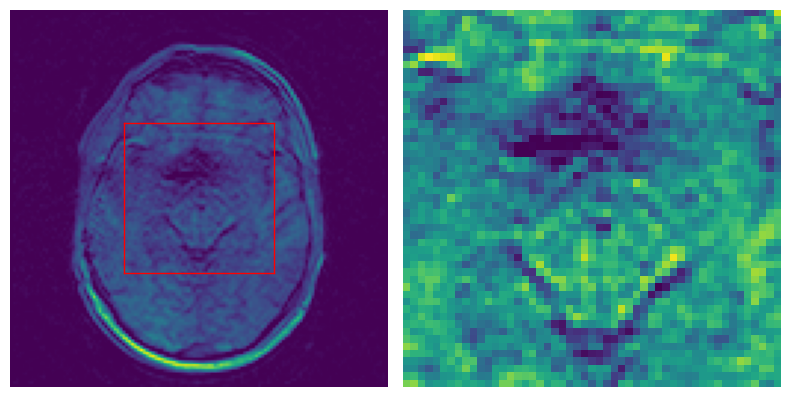

In [8]:
import matplotlib.pyplot as plt
import matplotlib.lines as line
fig, axs = plt.subplots(1, 2, figsize=(8, 10))
axs[0].imshow(dcm)
axs[0].add_artist(line.Line2D([y_bottom, y_bottom], [
                  y_top, y_bottom], color='red', linewidth=1))  # Høyre
axs[0].add_artist(line.Line2D([y_top, y_top], [y_top, y_bottom],
                  color='red', linewidth=1))       # Venstre
axs[0].add_artist(line.Line2D([y_bottom, y_top], [y_top, y_top],
                  color='red', linewidth=1))       # Topp
axs[0].add_artist(line.Line2D([y_bottom, y_top], [
                  y_bottom, y_bottom], color='red', linewidth=1))  # Bunn
axs[0].axis('off')
axs[1].imshow(dcm_crop)
axs[1].axis('off')
fig.tight_layout()
